In [48]:
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.base import clone

from sklearn.linear_model import SGDClassifier  # Stochastic Gradient Descent classifier for online training
from sklearn.ensemble import RandomForestClassifier  # ensembled decision trees
from sklearn.svm import SVC  # binary but can adapt to multiclass with OvO / OvR strategies

from sklearn.model_selection import StratifiedKFold  
# k-fold train_test_split (stratified): n_splits is the number of folds, >= 2
from sklearn.model_selection import StratifiedShuffleSplit  
# % test ratio train_test_split (stratified): n_splits is the number of shuffles, >= 1
from sklearn.model_selection import cross_val_score  # regular k-fold cross validation
from sklearn.model_selection import cross_val_predict  # returns predictions for all cv test folds

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score  # harmonic mean of precision & recall
from sklearn.metrics import precision_recall_curve  # by comparing decision function scores vs. thresholds
from sklearn.metrics import roc_curve  # TP rate against FP rate
from sklearn.metrics import roc_auc_score  # area under ROC curve: the greater the better


In [2]:
import sklearn
sklearn.__version__

'0.24.1'

In [3]:
# import the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
mnist['data'].head(2)  # attributes

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
mnist['target'].head(2)  # labels

0    5
1    0
Name: class, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [6]:
mnist['frame'].head(2)  # all columns (= data + target)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [7]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape  
# 28 x 28 = 784 pixels of black ink intesity [0,255] per digit, 70000 recorded digits

((70000, 784), (70000,))

In [8]:
X.iloc[0].shape

(784,)

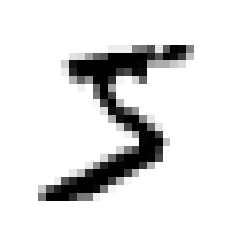

In [9]:
some_digit = X.iloc[0].values  # pixel array of the 0th digit (y[0])
some_digit_image = some_digit.reshape(28, 28)  # unflatten the pixel array

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off');

In [10]:
y.iloc[0]

'5'

In [11]:
# convert y labels from str to int
y = y.astype(np.uint8)

y.iloc[0]

5

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [13]:
# a simple "digit 5 detector" - binary classifier
y_train_5 = (y_train == 5)  # array of 0 & 1's
y_test_5 = (y_test == 5)

# stochastic gradient descent classifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [14]:
sgd_clf.predict([some_digit])  # some_digit should be 5

array([ True])

In [38]:
# a decision function score for this digit
decision_score = sgd_clf.decision_function([some_digit])

threshold = 0  # default threshold used in SGDClassifier()
decision_score > threshold  # should get the same result as above

array([ True])

In [39]:
decision_score  # set threshold to > 2165 would shift the prediction to False

array([2164.22030239])

The decision function (and predict_proba) returns an array of scores that represents whether a predicted sample for x_test by the classifier lies to the right or left side of the Hyperplane (threshold) and also how far from the HyperPlane.

It also tells us that how confidently each value predicted for x_test by the classifier is Positive ( large-magnitude Positive value ) or Negative ( large-magnitude Negative value).

We can manipulate classifier decisions by setting a decision threshold ourselves, such that we get desired precision or recall value if our project is precision-oriented or recall-oriented respectively.

In [15]:
# stratified k-fold cv (each fold retains the percentage of samples for each class)
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # 3 folds so 3 test runs

# for each of the 3 folds (tests):
for train_index, test_index in skfolds.split(X_train, y_train_5):
    # test the same copy of the original model (from above)
    clone_clf = clone(sgd_clf)
    
    # 2 folds for training and 1 fold for test
    X_train_folds = X_train.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_train_folds = y_train_5.iloc[train_index]
    y_test_fold = y_train_5.iloc[test_index]
    
    # fit and test the same model (for 3 times)
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print('accuracy ratio: ', n_correct / len(y_pred))

accuracy ratio:  0.9669
accuracy ratio:  0.91625
accuracy ratio:  0.96785


In [16]:
# regular k-fold cv
for score in cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy'):  # 3 folds
    print('accruacy ratio: ', score)

accruacy ratio:  0.95035
accruacy ratio:  0.96035
accruacy ratio:  0.9604


__Note: However, for classifiers, accuracy by ratio of correct predictions is NOT a good measure - should use confusion matrix instead.__

In [17]:
# model prediction for each of the 3 test folds - stacking to the full labels array
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [18]:
confusion_matrix(y_train_5, y_train_pred)  # (y, y_hat)

array([[53892,   687],
       [ 1891,  3530]])

In [19]:
precision_score(y_train_5, y_train_pred)  # TP/(TP+FP)

0.8370879772350012

In [20]:
recall_score(y_train_5, y_train_pred)  # TP/(TP+FN)

0.6511713705958311

In [21]:
f1_score(y_train_5, y_train_pred)  # 2 / (1 / precision + 1 / recall)

0.7325171197343846

In [22]:
# precision-recall trade off
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,  # default method returns y labels, but...
                             method="decision_function")  # this returns classifier decision scores for each y

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)  
# only works with binary classification

thresholds
# Increasing thresholds on the decision function used to compute precision and recall

array([-106527.45300471, -105763.22240074, -105406.2965229 , ...,
         38871.26391927,   42216.05562787,   49441.43765905])

In [23]:
np.sort(y_scores)  # thresholds ~ desicion function scores

array([-146348.56726174, -142300.00705404, -137588.97581744, ...,
         38871.26391927,   42216.05562787,   49441.43765905])

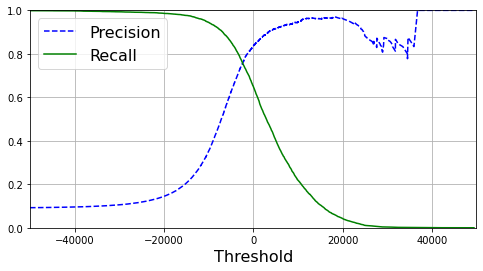

In [24]:
plt.figure(figsize=(8, 4))

# plot each precision and recall against their correspoding evaluation threshold
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')

plt.legend(fontsize=16)
plt.xlabel("Threshold", fontsize=16)
plt.grid(True)
plt.axis([-50000, 50000, 0, 1]);

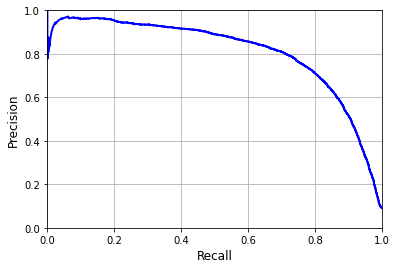

In [31]:
plt.plot(recalls, precisions, "b-", linewidth=2)
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.axis([0, 1, 0, 1])
plt.grid(True)

In [25]:
ind_p90 = np.argmax(precisions >= 0.90)  # index of the first precision value that satisfies the criteria

In [26]:
precisions[ind_p90]

0.9000345901072293

In [27]:
recalls[ind_p90]  # trade-off vs. the value above

0.4799852425751706

In [28]:
thresholds[ind_p90]  # this is the threshold value that gets the two values above

3370.019499143958

In [29]:
criteria_p90 = (y_scores >= thresholds[ind_p90])
precision_score(y_train_5, criteria_p90)  # same as indexing the "precisions" array above

0.9000345901072293

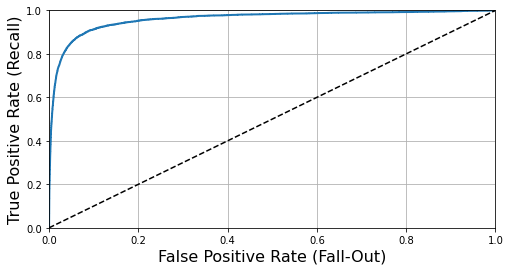

In [35]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)  # actual against decision func scores

plt.figure(figsize=(8, 4))

# plot ROC curve: 
plt.plot(fpr, tpr, linewidth=2)  # ROC curve
plt.plot([0, 1], [0, 1], 'k--')  # diagonal - the ROC curve should better stay as far away as possible

plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
plt.grid(True)    
plt.axis([0, 1, 0, 1]);

In [37]:
# the larger the area under the ROC (i.e. AUC value), the better
roc_auc_score(y_train_5, y_scores)  # actual against decision func scores

0.9604938554008616

In [42]:
# predict_proba vs. decision_function
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, 
                                    method='predict_proba')  # alternative to decision_function
y_probas_forest  # a column per class (binary classification here)

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

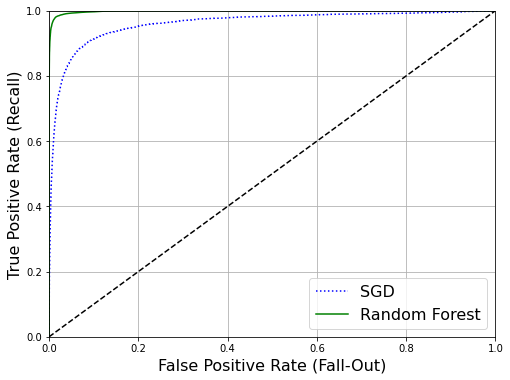

In [46]:
# get the ROC curve for RandomForestClassifier() with the positive scores from predict_proba
y_scores_forest = y_probas_forest[:, 1]  # proba of positive class (second column)
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)  # use the 'positive' column!

# plot the ROC curve for RandomForestClassifier() vs. SGDClassifier()
plt.figure(figsize=(8, 6))

plt.plot(fpr, tpr, 'b:', label="SGD")  # SGD, decision_function scores
plt.plot(fpr_forest, tpr_forest, 'g', label="Random Forest")  # forest, predict_proba scores
plt.plot([0, 1], [0, 1], 'k--')  # diagonal

plt.grid(True)
plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
plt.ylabel('True Positive Rate (Recall)', fontsize=16)
plt.axis([0, 1, 0, 1])
plt.legend(fontsize=16);  # Random forest is better due to a larger AUC

In [47]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145